# Predicting car prices using k-nearest neighbors (KNN) 
KNN is a simple machine learning technique that is used to output predictions based on the averaged values of interest in the 'k' number of most similar training data in terms of feature similarity. Data can be ranked according to similarity by calculating the euclidean distance between the features of the test data and the training data. Once the dataset is reordered such that rows with the lowest euclidean distance (most similar) come first, we can use a grid search technique to determine the most optimum hyperparameter - *k* to obtained the lowest root mean squared error (RMSE). For example, if we determine the optimum k to be 5, we select the first 5 ordered rows and calculate the average of the 5 values of interest to output the prediction. Off course, before reordering the data according to the euclidean distances, it's good to randomise the order of the data to avoid any potential bias.

This dataset is about cars and contains various features regarding cars. The aim is to see if it's possible to use these features to predict the price of the car.

## Cleaning the data

In [32]:
import pandas as pd
pd.set_option('display.max_columns', 500)

columns = ['symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors','body-style',
          'drive-wheels','engine-location','wheel-base','length','width','height','curb-weight',
          'engine-type','num-of-cylinders','engine-size','fuel-system','bore','stroke','compression-ratio',
          'horsepower','peak-rpm','city-mpg','highway-mpg','price']
cars = pd.read_csv('imports-85.data.txt', names = columns)

In [33]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [34]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-nul

Looks like the price variable we are interested in is on the last column. We'll first remove columns that aren't an integer or a float since we can't use KNN with text features. Then, we'll add the price column back in along with any other variables that weren't coded as the appropriate type. Let's also quickly get rid of '?' and replace it with NaNs.

In [35]:
cars2 = cars.copy().select_dtypes(include = ['int64', 'float64'])
cars2['price'] = cars['price']
cars2['normalized-losses'] = cars['normalized-losses']
cars2['bore'] = cars['bore']
cars2['stroke'] = cars['stroke']
cars2['horsepower'] = cars['horsepower']
cars2['peak-rpm'] = cars['peak-rpm']

In [36]:
import numpy as np
cars2.replace('?', np.nan,inplace = True)
cars2.head()

,symboling,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,price,normalized-losses,bore,stroke,horsepower,peak-rpm
0,3,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,13495,NaN,3.47,2.68,111,5000
1,3,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,16500,NaN,3.47,2.68,111,5000
2,1,94.5,171.2,65.5,52.4,2823,152,9.0,19,26,16500,NaN,2.68,3.47,154,5000
3,2,99.8,176.6,66.2,54.3,2337,109,10.0,24,30,13950,164,3.19,3.40,102,5500
4,2,99.4,176.6,66.4,54.3,2824,136,8.0,18,22,17450,164,3.19,3.40,115,5500


In [37]:
print(cars2.isnull().sum())
print('We have data on:', cars2.shape[0], 'cars')

symboling             0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
compression-ratio     0
city-mpg              0
highway-mpg           0
price                 4
normalized-losses    41
bore                  4
stroke                4
horsepower            2
peak-rpm              2
dtype: int64
We have data on: 205 cars


Unfortunately, it's not possible to run KNN with missing values. It's OK to lose a few cars in the dataset. However, there are 41 missing values for *normalized-losses*. That's 20% of the data we'd lose since there are only 205 cars. It's probably best to remove that column, and remove rows where there are missing values for *price, bore, stroke, horsepower* and *peak-rpm*.

In [38]:
cars2.drop('normalized-losses', axis = 1, inplace = True)

In [39]:
cars2.dropna(inplace = True)
print('Number of cars:',cars2.shape[0])

Number of cars: 195


We now have zero missing values and data on 195 cars. We lost 10 cars because of missing values in various columns but that's still a relatively small number. Now we can convert column into a float.

In [40]:
cars2 = cars2.astype('float')

## Normalising the data
The next step is to normalise the data such that $\bar x$ = 0 and s = 1. Essentially, we are converting the data points to z scores. This is especially important for multivariate KNN. For example, imagine 2 cars where the features are very similar bar one feature with a very big difference (perhaps that feature has a naturally high variance). In that case, the dissimilarity between these two cars would be over exaggerated due to the way euclidean distance is calculated. We do this for every column bar the feature we are interested in: *price*.

In [41]:
cars2 = (cars2 - cars2.mean()) / cars2.std()

In [42]:
cars2['price'] = cars['price']
cars2 = cars2.astype('float', inplace = True)

In [43]:
cars2.head(1)

,symboling,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,price,bore,stroke,horsepower,peak-rpm
0,1.791895,-1.679117,-0.437378,-0.837593,-2.11181,-0.020964,0.049755,-0.294176,-0.683346,-0.562432,13495.0,0.517224,-1.815604,0.204073,-0.212456


## Univariate KNN 
Let's begin predicting price using a single feature - thus univariate. I'll skip scipy for now and do things manually. First we randomise the order of the data. Then, we try to predict the price based on the horsepower of the car. This is a reasonable place to start because it makes sense that more powerful cars will cost more.

In [44]:
# Randomise
cars2 = cars2.iloc[np.random.permutation(cars2.shape[0])]
cars2.reset_index(drop = True,inplace = True)

# Split 
train = cars2.iloc[:147].copy()
test = cars2.iloc[147:,].copy()

def univ_knn(train,tr_feature,new_val,k = 5):
    data = train.copy()
    # Euclidean distance for 1 variable
    data['distance'] = np.sqrt((new_val - train[tr_feature])**2)
    data.sort_values('distance',inplace = True, ascending = True)
    pred_val = data.head(k)['price'].mean()
    return pred_val

In [45]:
predicted_values = []
for idx, current_row in test.iterrows():
    new_val = current_row['horsepower']
    predicted_values.append(univ_knn(train, 'horsepower', new_val, k=3))

In [46]:
rmse = np.sqrt(np.sum((test['price'] - predicted_values)**2) / len(test))
temp_test = test.copy()
temp_test['predicted'] = predicted_values

print(temp_test.head(1))
print('The rmse of our univariate KNN based on horsepower is:', rmse)
print('The mean price of a car is:', temp_test['price'].mean())

     symboling  wheel-base    length     width    height  curb-weight  \
147   0.979292    -0.84742 -1.359115 -0.696912 -1.277356    -1.172063   

     engine-size  compression-ratio  city-mpg  highway-mpg   price     bore  \
147    -0.867368          -0.195705  0.878817     1.048271  6189.0 -1.32192   

       stroke  horsepower  peak-rpm    predicted  
147 -0.064651   -0.931398  0.855301  6877.666667  
The rmse of our univariate KNN based on horsepower is: 5061.870542028832
The mean price of a car is: 12570.354166666666


So based on the 5 most similar cars in terms of *horsepower*, we managed to predict some prices. Based off the rmse, We should expect our predicted prices to be off by roughly $5000.

## Grid searching for the best k-value

In [47]:
import matplotlib.pyplot as plt

k = np.arange(1,21)
overall_rmse = []

for i in k:
    predicted_values = []
    for idx, current_row in test.iterrows():
        new_val = current_row['horsepower']
        predicted_values.append(univ_knn(train, 'horsepower', new_val, k=i))
    rmse = np.sqrt(np.sum((test['price'] - predicted_values)**2) / len(test))
    overall_rmse.append(rmse)

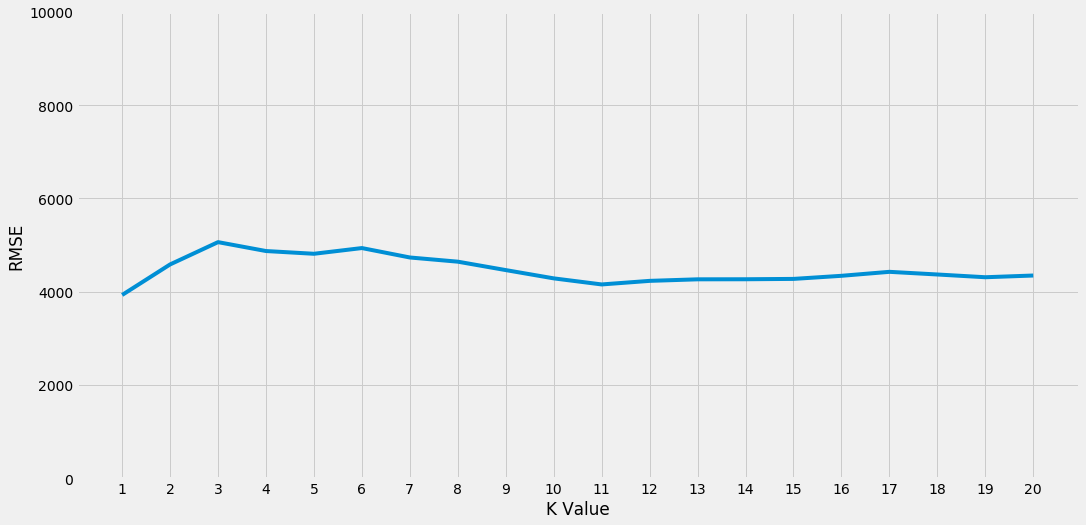

In [48]:
plt.figure(figsize =  (16,8))
plt.style.use('fivethirtyeight')
plt.plot(np.arange(1,21),overall_rmse)
plt.xticks(np.arange(1,21))
plt.xlabel('K Value')
plt.ylabel('RMSE')
plt.ylim(0,1e4)
plt.show()

Looks like a k value of 1 results in the lowest RMSE. This is quite unusual as for most other features we'd expect the RMSE to fall for the first few *k*'s and then rebound slightly. 

## Extending the function
Now, we try and find the RMSE values for all features one at a time to get a better understanding of which features seem to be good at predicting price. This time scipy will be used.

In [49]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

In [50]:
def train_test(train_cols, target_col, df, k=5):
    if not isinstance(train_cols, (str,list)):
        raise TypeError('train_cols must be a list or a string')
    data = df.copy()
    train = data.iloc[:round(cars2.shape[0]*.75),]
    test = data.iloc[round(cars2.shape[0]*.75):,]
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    if type(train_cols) == str:
        knn.fit(train[[train_cols]], train[target_col])
        predictions = knn.predict(test[[train_cols]])
    elif type(train_cols) == list:
        knn.fit(train[train_cols], train[target_col])
        predictions = knn.predict(test[train_cols])
    mse = mean_squared_error(test[target_col], predictions)
    return predictions, mse, np.sqrt(mse)

In [51]:
# Randomise
cars2 = cars2.iloc[np.random.permutation(cars2.shape[0])]
cars2.reset_index(drop = True,inplace = True)

# Split 
train = cars2.iloc[:147].copy()
test = cars2.iloc[147:,].copy()

To get an idea of which features to use for our multivariate KNN, let's first get the RMSES values for univariate KNN for all features.

In [52]:
import operator

cols = list(cars2)
cols.remove('price')
rmse_dict = {}

for current_col in cols:
        pred, mse, rmse = train_test(train_cols = current_col, target_col='price', df = cars2,
                            k = 5)
        rmse_dict[current_col + ' RMSE:'] = rmse

sorted(rmse_dict.items(), key = operator.itemgetter(1))

[('horsepower RMSE:', 2581.6137637737606),
 ('engine-size RMSE:', 2624.6644257419084),
 ('city-mpg RMSE:', 2749.2153880327237),
 ('curb-weight RMSE:', 4033.5203500016646),
 ('length RMSE:', 4448.0629198310035),
 ('width RMSE:', 5219.899545284098),
 ('highway-mpg RMSE:', 5236.2951257622635),
 ('wheel-base RMSE:', 5458.325697987078),
 ('bore RMSE:', 5724.895546752316),
 ('compression-ratio RMSE:', 6000.320664832533),
 ('stroke RMSE:', 7409.925380163544),
 ('height RMSE:', 7511.1753631722995),
 ('peak-rpm RMSE:', 7554.995418089077),
 ('symboling RMSE:', 8151.770455050653)]

Looks like *horsepower* and *engine-size*, followed by *city-mpg* and *curb-weight* are really good predictors of price. That makes sense because *horsepower* and *engine-size* are probably correlated, and *city-mpg* and *curb-weight* are probably negatively correlated. Let's confirm that.

In [60]:
from scipy.stats import pearsonr

corr, p = pearsonr(cars2['horsepower'], cars2['engine-size'])
corr2, p2 = pearsonr(cars2['city-mpg'], cars2['curb-weight'])

print('horsepower and engine-size, r =', corr)
print('city-mpg and curb-weight, r =', corr2)

horsepower and engine-size, r = 0.8426910201423584
city-mpg and curb-weight, r = -0.7721708592057597


Let's see which *k* value results in the lowest RMSE for all these features. I'll print the raw output and then graph it.

In [54]:
import operator

k = np.linspace(2,20, 10).astype(int)
cols = list(cars2)
cols.remove('price')
rmse_dict = {}

for current_col in cols:
    rmse_dict[current_col] = {}
    for i in range(len(k)):
        pred, mse, rmse = train_test(train_cols = current_col, 
                                 target_col='price', df = cars2,k = k[i])
        rmse_dict[current_col][str(k[i])] = rmse
rmse_dict

{'symboling': {'2': 7104.520362172989,
  '4': 7545.443954764344,
  '6': 7405.677866292663,
  '8': 6849.155280037369,
  '10': 7421.739437267646,
  '12': 7364.070771971766,
  '14': 7160.020636601238,
  '16': 6973.019864835852,
  '18': 6856.916582668037,
  '20': 6702.434916566988},
 'wheel-base': {'2': 6619.771093597773,
  '4': 6104.73567074725,
  '6': 5542.5901851316285,
  '8': 4908.7742064735785,
  '10': 4833.246614220875,
  '12': 4924.206066225607,
  '14': 4940.181581364324,
  '16': 4996.084964938184,
  '18': 4896.149020767249,
  '20': 4907.2415644262555},
 'length': {'2': 3799.5501264314576,
  '4': 3947.978702023689,
  '6': 4261.118530697434,
  '8': 4059.296283584252,
  '10': 4152.085791846929,
  '12': 4263.217670496947,
  '14': 4437.981618730327,
  '16': 4353.532774479022,
  '18': 4364.469955324438,
  '20': 4362.129058271936},
 'width': {'2': 4465.404862577938,
  '4': 5306.439600348133,
  '6': 5023.510806792767,
  '8': 5134.643547077876,
  '10': 5008.820032844918,
  '12': 5283.785057

Here are the average RMSE values across all different *k* values:

In [55]:
avg_rmse = {}

for current_feature in rmse_dict:
    feature = rmse_dict[current_feature]
    keys = feature.keys()
    rmse = []
    for current_key in keys:
        rmse.append(feature[current_key])
    avg_rmse[current_feature+' mean'] = np.mean(rmse)

sorted(avg_rmse.items(), key = operator.itemgetter(1))

[('city-mpg mean', 3016.6013383519385),
 ('engine-size mean', 3091.4460619401325),
 ('horsepower mean', 3184.254871543001),
 ('curb-weight mean', 3842.0987203316777),
 ('length mean', 4200.136051188643),
 ('width mean', 5129.16001724412),
 ('highway-mpg mean', 5165.566742011964),
 ('wheel-base mean', 5267.298096789272),
 ('compression-ratio mean', 6072.847693777062),
 ('bore mean', 6127.288161006991),
 ('stroke mean', 7134.185036821368),
 ('symboling mean', 7138.29996731789),
 ('height mean', 7229.88841882306),
 ('peak-rpm mean', 7881.529194464098)]

And here is a plot showing the varying RMSE values for *k* from 1-10.

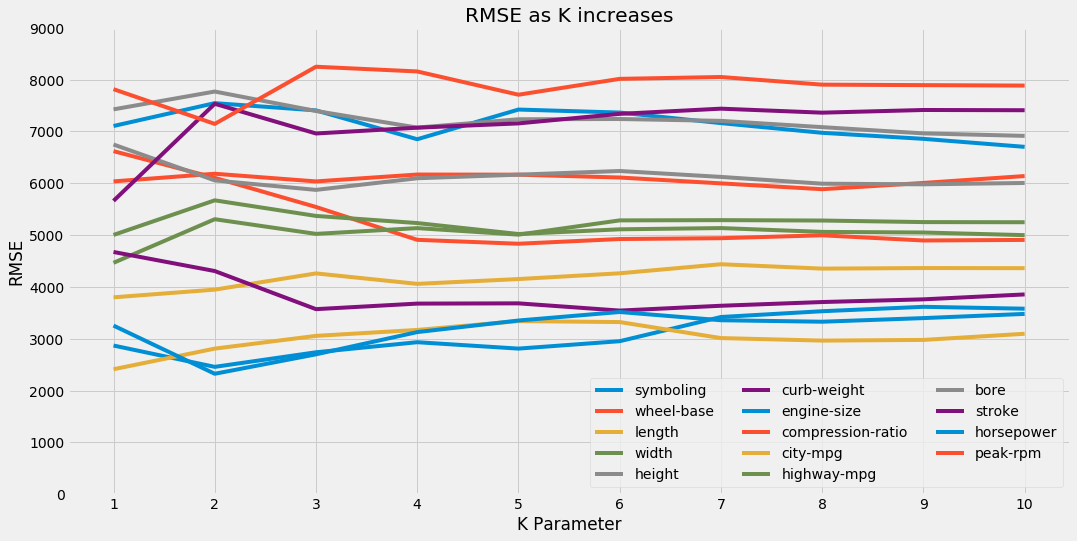

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize = (16,8))
plt.ylim(0,9e3)
plt.xticks(k)
plt.xlabel('K Parameter')
plt.ylabel('RMSE')
plt.title('RMSE as K increases')

for current_feature in rmse_dict:
    feature = rmse_dict[current_feature]
    keys = feature.keys()
    rmse = []
    for current_key in keys:
        rmse.append(feature[current_key])
    plt.plot(k,rmse, label = current_feature)
    plt.legend(loc = 'lower right', ncol = 3)

## Multivariate KNN
This time, we'll take other features into consideration too. This will most likely reduce the RMSE further. Let's first try putting everything in.

In [26]:
cols = list(cars2)
cols.remove('price')

pred, mse, rmse = train_test(train_cols = cols, target_col='price', df = cars2,
                            k = 5)

print('The RMSE with all features is:', rmse)

The RMSE with all features is: 4740.013440005057


This tells us that using all the features, our predictions are roughly $4,700 dollars off on average. However, if you check the chart above this isn't particularly impressive as we managed to get to this level with just one feature. It's important to be selective with what you put in the model. Below, I'll try a better combination of features and see if we can get a lower error value. I'll use a k value of 3 for now.

In [59]:
# 2 feature model
cols = ['city-mpg', 'engine-size']
pred, mse, rmse = train_test(train_cols = cols, target_col='price', df = cars2,
                            k = 3)
print('The RMSE with city-mpg and engine-size is:', rmse)

# 3 feature model
cols.append('horsepower')
pred, mse, rmse = train_test(train_cols = cols, target_col='price', df = cars2,
                            k = 3)
print('The RMSE with city-mpg, engine-size and horsepower is:', rmse)

#4 feature model
cols.append('curb-weight')
pred, mse, rmse = train_test(train_cols = cols, target_col='price', df = cars2,
                            k = 3)
print('The RMSE with city-mpg, engine-size, horsepower and curb-weight is:', rmse)

The RMSE with city-mpg and engine-size is: 2192.6579233221682
The RMSE with city-mpg, engine-size and horsepower is: 1645.8542213433825
The RMSE with city-mpg, engine-size, horsepower and curb-weight is: 2116.5119896347323


That looks promising. The RMSE has gone down even further. Now let's optimize the *k* parameter using a grid search tactic. I'll refer to the 2 feature model as model 1, the 3 feature model as model 2, and the 4 feature model as model 3.

RMSE for model 1 k = 1: 2821.363543554421
RMSE for model 1 k = 2: 2526.2708218451407
RMSE for model 1 k = 3: 2192.6579233221682
RMSE for model 1 k = 4: 2061.3149022591165
RMSE for model 1 k = 5: 1866.5381904280794
RMSE for model 1 k = 6: 1853.765112827786
RMSE for model 1 k = 7: 1978.4432811539036
RMSE for model 1 k = 8: 2263.94443138361
RMSE for model 1 k = 9: 2506.9536247091664
RMSE for model 1 k = 10: 2775.074359768563
RMSE for model 2 k = 1: 2563.942273061513
RMSE for model 2 k = 2: 1924.9487774791223
RMSE for model 2 k = 3: 1645.8542213433825
RMSE for model 2 k = 4: 1554.4157045005559
RMSE for model 2 k = 5: 1596.9183356115127
RMSE for model 2 k = 6: 1869.7857806835138
RMSE for model 2 k = 7: 1973.8184566659243
RMSE for model 2 k = 8: 1947.9142073632115
RMSE for model 2 k = 9: 2153.0315710249547
RMSE for model 2 k = 10: 2354.316503352764
RMSE for model 3 k = 1: 1721.0496915592898
RMSE for model 3 k = 2: 1576.9761428449197
RMSE for model 3 k = 3: 2116.5119896347323
RMSE for model 3

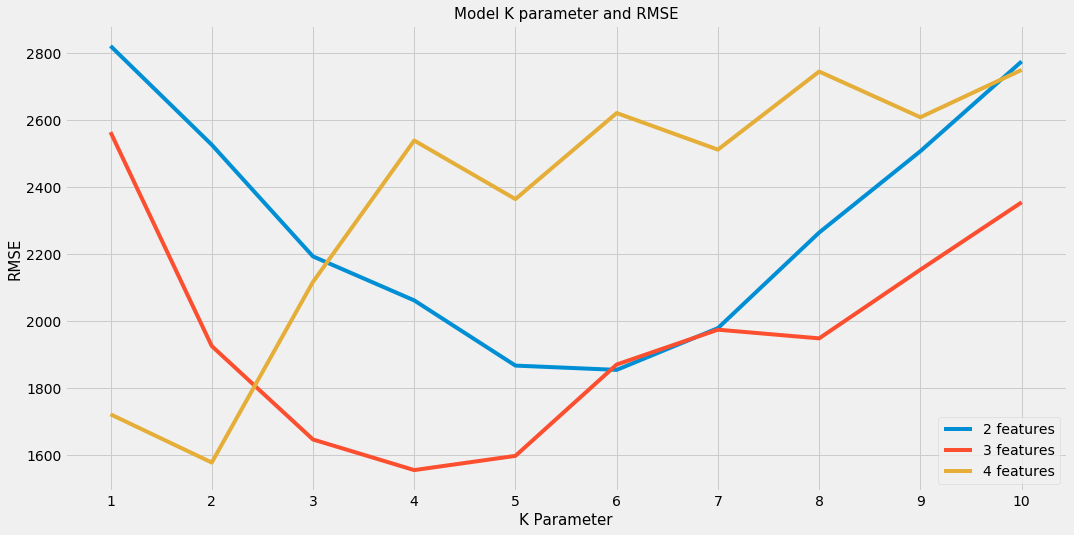

In [75]:
k = np.linspace(1,10,10).astype(int)

models = {'model1':['city-mpg','engine-size'],
         'model2':['city-mpg','engine-size','horsepower'],
         'model3':['city-mpg','engine-size','horsepower','curb-weight']}

rmse_1 = []
rmse_2 = []
rmse_3 = []

for idx, current_model in enumerate(models):
    features = models[current_model]
    for current_k in k:
        pred, mse, rmse = train_test(train_cols = features, target_col='price', df = cars2,
                            k = current_k)
        print('RMSE for model {}'.format(idx+1),  'k = {}:'.format(current_k),rmse)
        if idx == 0:
            rmse_1.append(rmse)
        elif idx == 1:
            rmse_2.append(rmse)
        else:
            rmse_3.append(rmse)
    
plt.figure(figsize = (16,8))
plt.plot(k, rmse_1, label = '2 features')
plt.plot(k, rmse_2, label = '3 features')
plt.plot(k, rmse_3, label = '4 features')
plt.xticks(k)
plt.xlabel('K Parameter', fontsize = 15)
plt.ylabel('RMSE',fontsize = 15)
plt.title('Model K parameter and RMSE', fontsize = 15)
plt.legend()
plt.show()

Judging by this, it would probably be best to select the model containing the three features: ***city-mpg, engine-size*** and ***horsepower*** and use a k-value of 4 for this model. If we do this, our predictions seem to be off on average by only around \$1550 for this train/test split. This model does a much better job at predicting car prices compared to a univariate model or a model where we just put in all the features.

## K-Fold cross validation
So far, we have split the data into a 75/25 training/testing split, trained the model on the training data and calculated the RMSE using the true values from the testing set and the predicted values. However, one way to improve the accuracy estimate of our model is to use a technique called cross validation. Although there are many types of cross validation, I will focus on the K-Fold method. 

A simple way to think about it is to imagine assigning a *fold* or a label to each row. For example, let's say we want to do 5 folds in a dataset with 3,000 entries. One way to achieve that would be to divide the entries into 6 equal sizes and assign values of 1-5 as an extra column. Thus, the first 600 rows would labeled 1, rows 600-1200 would be labeled 2, rows 1200-1800 would be labeled 3 and so on until label 5. After that, you would use the rows labeled 1-4 as your training set and rows labeled 5 as your test set to obtain the error metric - I will use mean squared error (MSE). You then move on to use row 4 as your test set, while using rows 1,2,3 and 5 as the training set - once again calculating the MSE. This continues until you have used all fold labels as a test set. After obtaining five error metrics, the average error is calculated.

Let's make an extension to the previous function.

In [147]:
def train_test(train_cols, target_col, df, k=5,kfold = True):
    if not isinstance(train_cols, (str,list)):
        raise TypeError('train_cols must be a list or a string')
    if not isinstance(kfold, bool):
        raise TypeError('kfold argument must be boolean')
    if kfold == False:        
        data = df.copy()
        train = data.iloc[:round(cars2.shape[0]*.75),]
        test = data.iloc[round(cars2.shape[0]*.75):,]
        knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
        if type(train_cols) == str:
            knn.fit(train[[train_cols]], train[target_col])
            predictions = knn.predict(test[[train_cols]])
        elif type(train_cols) == list:
            knn.fit(train[train_cols], train[target_col])
            predictions = knn.predict(test[train_cols])
        mse = mean_squared_error(test[target_col], predictions)
        return predictions, mse, np.sqrt(mse)
    else:
        try:
            n_folds = int(input('Enter as integer the number of folds \n'))
        except ValueError:
            print('You need to enter an INTEGER value for nfolds')
        shuffle = bool(input('Shuffle data? Enter any character to shuffle, press enter to skip \n'))
        kf = KFold(n_splits=n_folds, shuffle = shuffle, random_state = 1)
        knn = KNeighborsRegressor(n_neighbors=k)
        if isinstance(train_cols, str):
            mses = cross_val_score(estimator=knn,X=df[[train_cols]],y=df[target_col],
                           scoring="neg_mean_squared_error",cv=kf)
        else:
            mses = cross_val_score(estimator=knn,X=df[train_cols],y=df[target_col],
                            scoring="neg_mean_squared_error",cv=kf)
        return np.mean(np.sqrt(np.abs(mses)))

Let's cross validate our 2,3 and 4 feature models to gain a better error estimate.

In [148]:
rmse_1 = train_test(train_cols = models['model1'], target_col='price', df = cars2,
                            k = 6,kfold = True)

rmse_2 = train_test(train_cols = models['model2'], target_col='price', df = cars2,
                            k = 4,kfold = True)

rmse_3 = train_test(train_cols = models['model3'], target_col='price', df = cars2,
                            k = 2,kfold = True)

Enter as integer the number of folds 
10
Shuffle data? Enter any character to shuffle, press enter to skip 

Enter as integer the number of folds 
10
Shuffle data? Enter any character to shuffle, press enter to skip 

Enter as integer the number of folds 
10
Shuffle data? Enter any character to shuffle, press enter to skip 



In [149]:
print('The twp feature model has an RMSE of {}\n'.format(rmse_1),
      'The three feature model has an RMSE of {}\n'.format(rmse_2),
      'The four feature model has an RMSE of {}'.format(rmse_3))

The twp feature model has an RMSE of 2825.9558530345557
 The three feature model has an RMSE of 2606.202458477728
 The four feature model has an RMSE of 2362.5006512768036


After cross validating, it looks like the average RMSE of the 4 feature model: ***city-mpg, engine-size, horsepower*** and ***curb-weight*** is the lowest. On average, that model had an error of around $2,360. This is a much better model than any of our univariate models.